In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pdb
import collections
import numpy as np
from tqdm import tqdm
import seaborn as sn
import matplotlib.pyplot as plt

In [0]:
csv_name = "Crimes_-_2018.csv"
df = pd.read_csv(csv_name)
print(df.head())

         ID Case Number  ...  Longitude                       Location
0     24954     G284899  ... -87.696988  (41.907312308, -87.696987788)
1  11980920    JD151255  ...        NaN                            NaN
2  11981042    JD151588  ...        NaN                            NaN
3  11909273    JC532244  ... -87.720879   (41.93254643, -87.720878763)
4  11609098    JB559732  ...        NaN                            NaN

[5 rows x 22 columns]


Drop totally unrelated features

In [0]:
totally_unrelated_features = ['ID', 'Case Number', 'Description', 'Year', 'Block']
df = df.drop(totally_unrelated_features, axis=1)
previous_length = len(df)
print(df.head())

                     Date  IUCR  ...  Longitude                       Location
0  11/15/2018 09:01:00 PM  0110  ... -87.696988  (41.907312308, -87.696987788)
1  03/01/2018 04:45:00 PM  0560  ...        NaN                            NaN
2  01/01/2018 01:00:00 PM  5000  ...        NaN                            NaN
3  11/05/2018 12:00:00 AM  0460  ... -87.720879   (41.93254643, -87.720878763)
4  12/19/2018 12:37:00 PM  2014  ...        NaN                            NaN

[5 rows x 17 columns]


Try to remove the NAN values

In [0]:
df = df.dropna()
print(f"Dropped data due to NAN: {previous_length - len(df)}, percentage: {(previous_length - len(df))/previous_length}")

Dropped data due to NAN: 5104, percentage: 0.019052169498611403


Drop more features by analyzing the data

In [0]:
def visualize_single_type_conditional_prob(data_res, target_name, show_data_type):
	data_res = data_res.loc[show_data_type]
	data_res = pd.DataFrame({'prob': data_res}).reset_index()
	sn.set(style="whitegrid")
	f, ax = plt.subplots(figsize=(15, 6))
	sn.set_color_codes("pastel")
	sn.barplot(x="prob", y=target_name, data=data_res, color="b", orient='h')
	ax.set(ylabel=target_name+':'+show_data_type,
	       xlabel=f"Probability of {show_data_type} in {target_name} conditioned on Primary Type")
	sn.despine(left=True, bottom=True)
	plt.show()

def visualize_all_types_of_conditional_prob(data_res, data_type):
	data_res = pd.DataFrame({'prob' : data_res}).reset_index()
	data_res = data_res.drop_duplicates(['Primary Type'])
	for index, row in data_res.iterrows():
		if data_res.loc[index, data_type] == False:
			data_res.loc[index, 'prob'] = 1 - data_res.loc[index, 'prob']
			data_res.loc[index, data_type] = True
	sn.set(style="whitegrid")
	f, ax = plt.subplots(figsize=(15, 6))
	sn.set_color_codes("pastel")
	sn.barplot(x="prob", y="Primary Type", data=data_res, color="b")
	ax.set(xlim=(0, 1), ylabel="",
	       xlabel=f"Probability of {data_type} conditioned on Primary Type")
	sn.despine(left=True, bottom=True)
	plt.subplots_adjust(left=0.24)
	plt.show()

Calculate conditional prob

In [0]:
def conditional_prob_cal(df, target_name, apply_laplace_smoothing = False, visualize=False, visualize_single_type_data=False, show_data_type=None):
	'Calculate the conditional probability of each Primary Type given each values of target_name'
	conditional_counts = df.groupby('Primary Type')[target_name].value_counts()
	total_counts = df.groupby('Primary Type')[target_name].count()

	'Initialize with 1'
	smooth_item = [1] * len(list(collections.Counter(df['Primary Type']).keys()))

	if apply_laplace_smoothing:
		'Count the total number of Primary Type'
		class_number = len(collections.Counter(df[target_name]))
		'Add one to numerator'
		conditional_counts += 1
		'Add class number to the denominator'
		total_counts += class_number
		'Divide & calculate prob for the laplace smoothing'
		for index, item in enumerate(smooth_item):
			smooth_item[index] = item/total_counts.loc[index]
		smooth_item = pd.DataFrame(index=sorted(list(collections.Counter(df['Primary Type']).keys())), columns=[target_name], data=smooth_item)
	'Calculate conditional prob'
	conditional_prob = conditional_counts / total_counts
	if visualize_single_type_data:
		visualize_single_type_conditional_prob(conditional_prob, target_name, show_data_type)
	if visualize:
		visualize_all_types_of_conditional_prob(conditional_prob, target_name)
	# print(conditional_prob)
	return conditional_prob, smooth_item

Analyze features: Arrest, Domestic, FBI Code, Beat, Ward, District, X Coordinate, Y Coordinate, Latitude, Longitude, Location

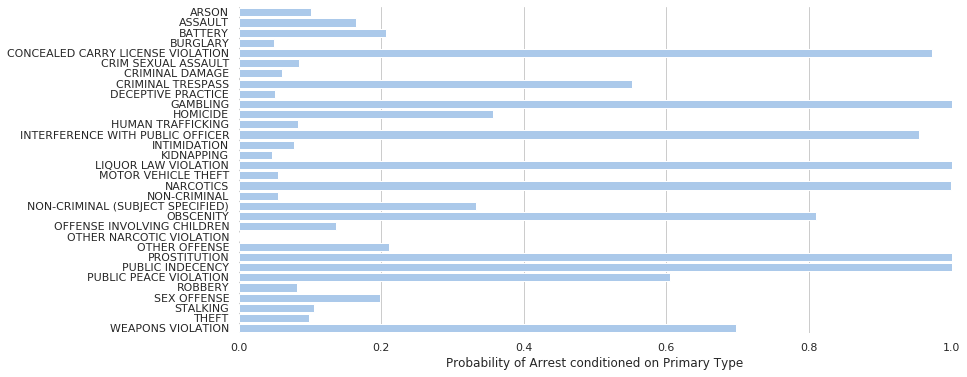

In [0]:
_, _ = conditional_prob_cal(df, 'Arrest', visualize=True)

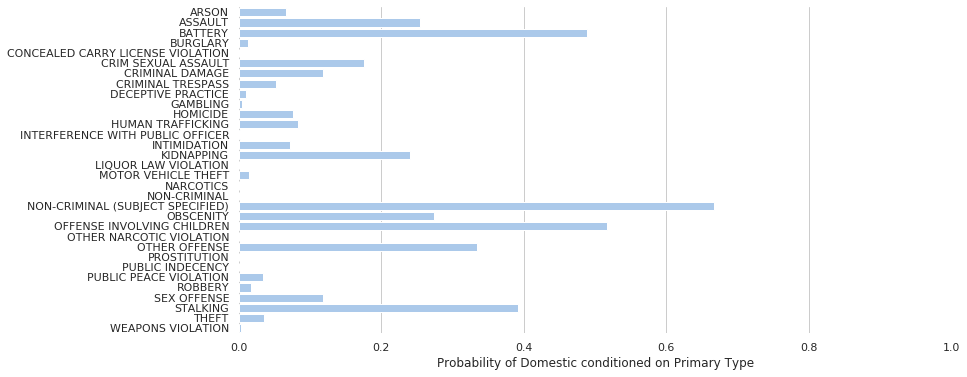

In [0]:
_, _ = conditional_prob_cal(df, 'Domestic', visualize=True)

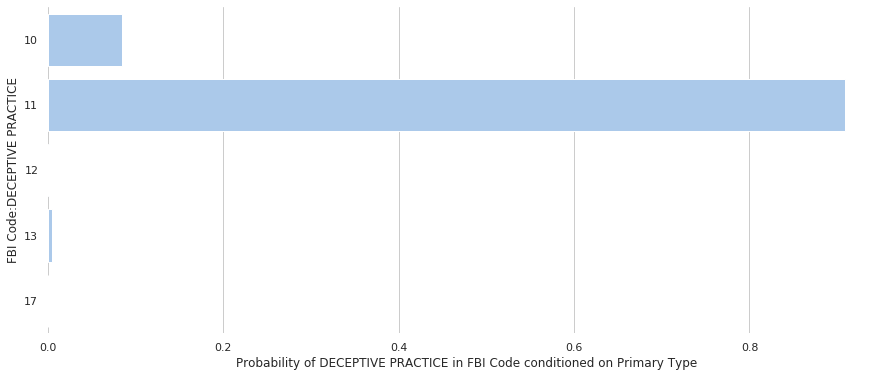

In [0]:
'FBI Code: Indicates the classification of the crimes.'
_, _ = conditional_prob_cal(df, 'FBI Code', visualize_single_type_data=True, show_data_type='DECEPTIVE PRACTICE')

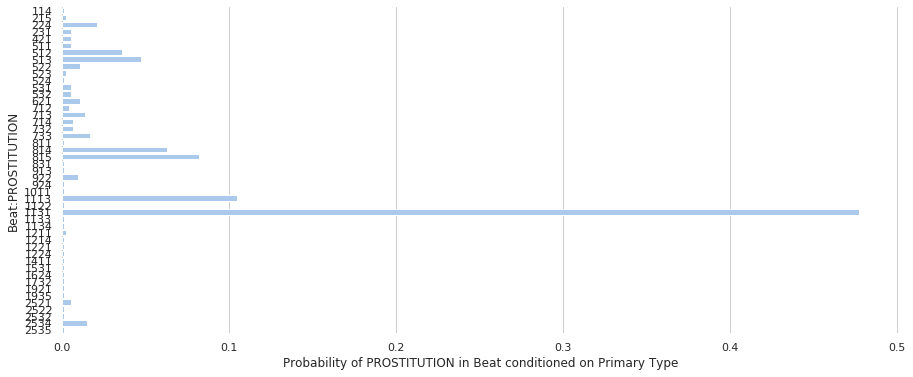

In [0]:
_, _ = conditional_prob_cal(df, 'Beat', visualize_single_type_data=True, show_data_type='PROSTITUTION')

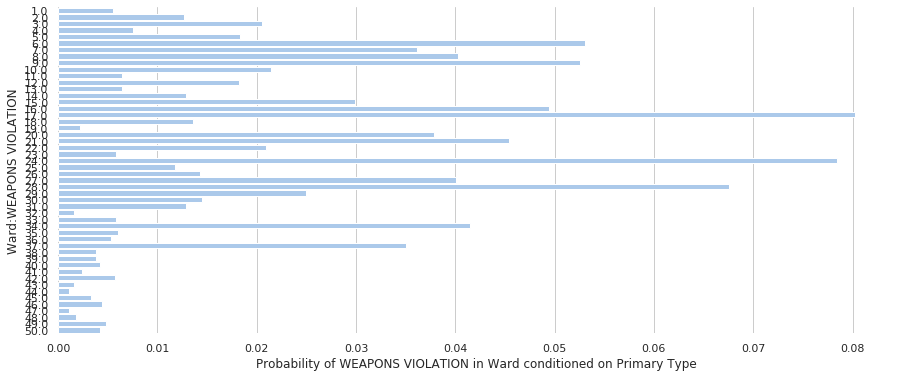

In [0]:
_, _ = conditional_prob_cal(df, 'Ward', visualize_single_type_data=True, show_data_type='WEAPONS VIOLATION')

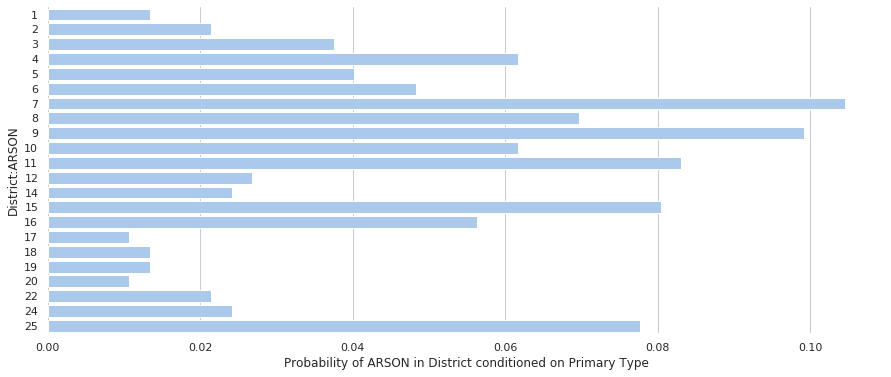

In [0]:
_, _ = conditional_prob_cal(df, 'District', visualize_single_type_data=True, show_data_type='ARSON')

Update data here is totally unrelated to the Primary type, so we should remove it

In [0]:
print(df[['Date', 'Updated On']].head())

                      Date              Updated On
0   11/15/2018 09:01:00 PM  02/15/2020 03:46:27 PM
3   11/05/2018 12:00:00 AM  02/15/2020 03:46:27 PM
22  06/19/2018 12:00:00 AM  02/13/2020 03:50:08 PM
28  01/01/2018 12:00:00 PM  02/12/2020 03:45:35 PM
35  07/17/2018 04:00:00 AM  02/11/2020 03:50:36 PM


Location is duplicated with Latitude & Longitude here. Moreover, since the Beat, District, Ward above have cotained the location information, we may ignore the Latitude & Longitude. Similarily, the X Coordinate & Y Coordinate should be removed.

In [0]:
print(df[['Latitude', 'Longitude', 'Location']].head())

     Latitude  Longitude                       Location
0   41.907312 -87.696988  (41.907312308, -87.696987788)
3   41.932546 -87.720879   (41.93254643, -87.720878763)
22  41.890206 -87.754205  (41.890205665, -87.754205244)
28  41.889497 -87.618295  (41.889497462, -87.618294943)
35  41.992027 -87.710049  (41.992026512, -87.710049481)


In [50]:
prob, _ = conditional_prob_cal(df, 'Location Description')
prob

Primary Type  Location Description
0             0                       0.545000
              2                       0.103333
              28                      0.083333
              5                       0.053333
              18                      0.041667
                                        ...   
29            80                      0.071429
30            1                       0.333333
              2                       0.333333
              6                       0.333333
31            45                      1.000000
Name: Location Description, Length: 1519, dtype: float64

IUCR: directly link to the Primary Type & description. I decided not to use it

In [0]:
df = df.drop(['IUCR', 'X Coordinate', 'Y Coordinate', 'Updated On', 'Latitude', 'Longitude', 'Location'], axis=1)
df.head()

,Date,Primary Type,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code
0,11/15/2018 09:01:00 PM,HOMICIDE,STREET,True,False,1423,14,26.0,24.0,01A
3,11/05/2018 12:00:00 AM,BATTERY,RESIDENCE,False,False,2523,25,30.0,21.0,08B
22,06/19/2018 12:00:00 AM,CRIM SEXUAL ASSAULT,RESIDENCE,False,False,1532,15,37.0,25.0,02
28,01/01/2018 12:00:00 PM,THEFT,APARTMENT,True,False,1834,18,42.0,8.0,06
35,07/17/2018 04:00:00 AM,CRIM SEXUAL ASSAULT,RESIDENCE,False,False,1711,17,50.0,13.0,02


Turn datetime to hours

In [0]:
df['Date'] = pd.to_datetime(df['Date'], format="%m/%d/%Y %I:%M:%S %p").dt.hour
df.head()

,Date,Primary Type,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code
0,21,HOMICIDE,STREET,True,False,1423,14,26.0,24.0,01A
3,0,BATTERY,RESIDENCE,False,False,2523,25,30.0,21.0,08B
22,0,CRIM SEXUAL ASSAULT,RESIDENCE,False,False,1532,15,37.0,25.0,02
28,12,THEFT,APARTMENT,True,False,1834,18,42.0,8.0,06
35,4,CRIM SEXUAL ASSAULT,RESIDENCE,False,False,1711,17,50.0,13.0,02


For convenince, factorize each feature here

In [0]:
df = df.apply(lambda x: pd.factorize(x)[0])
df.head()

,Date,Primary Type,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code
0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,1,1,1,1,1
22,1,2,1,1,0,2,2,2,2,2
28,2,3,2,0,0,3,3,3,3,3
35,3,2,1,1,0,4,4,4,4,2


Split train & test set

In [0]:
train, test = train_test_split(df, test_size=0.2)

Impl Naive Bayes here. First, get the prob of each Primary Type

In [0]:
prob_y = train['Primary Type'].value_counts()/len(train)

Then, for each feature, get the conditional prob given Primary Type

In [0]:
prob_x_given_y = {}
prob_of_item_not_contained = {}
for single_type in train:
	if single_type == 'Primary Type':
		continue
	prob_x_given_y[single_type], prob_of_item_not_contained[single_type] = conditional_prob_cal(train, single_type, apply_laplace_smoothing=True)
print("training process done")

training process done


In [0]:
def Normalize_dict(input_dict):
	'Normalize the values of the dict'
	sum_value = sum(input_dict.values())
	output_dict = {k: v / sum_value for k, v in input_dict.items()}
	return output_dict

def visualize_Normalized_dict(input_dict, target_type):
	input_dict = pd.DataFrame.from_dict(input_dict, orient='index', columns=['prob'])
	input_dict = input_dict.reset_index()
	sn.set(style="whitegrid")
	f, ax = plt.subplots(figsize=(15, 6))
	sn.set_color_codes("pastel")
	sn.barplot(x="prob", y="index", data=input_dict, color="b", orient='h')
	ax.set(ylabel="Class",
	       xlabel=f"Probability of Primary Type, ground truth is: {target_type}")
	sn.despine(left=True, bottom=True)
	plt.show()

def evaluate_single_case(single_case, target_type, visualize_dict=False):
	prob_res_dict = {}
	for (candidate_primary_type, candidate_prob) in prob_y.iteritems():
		'candidate_primary_type here is the Primary Type'
		res_prob = candidate_prob
		for single_type, value in single_case.iteritems():
			'single_type is the type of features. For example, Date, Location Description, Arrest, etc.'
			if single_type == 'Primary Type':
				assert 1==0, 'input should not contain the Primary Type, check your code'
			conditional_prob = prob_x_given_y[single_type].loc[candidate_primary_type]
			if value not in conditional_prob:
				current_type_prob = prob_of_item_not_contained[single_type].loc[candidate_primary_type][0]
			else:
				current_type_prob = conditional_prob.loc[value]
			res_prob *= current_type_prob
		prob_res_dict[candidate_primary_type] = res_prob
	if visualize_dict:
		visualize_Normalized_dict(Normalize_dict(prob_res_dict), target_type)
	return pd.Series(prob_res_dict).idxmax()

Evaluate the results, draw the confusion matrix

In [0]:
confusion_matrix = np.zeros(shape=(32, 32))
result = []
for index in tqdm(range(len(test))):
	row = test.iloc[index]
	target = row['Primary Type']
	pred_res = evaluate_single_case(row.drop('Primary Type'), target_type=target)
	result.append(target==pred_res)
	confusion_matrix[target][pred_res] += 1
print(f"With naive bayes, the accuracy here is: {np.asarray(result).mean()}")

100%|██████████| 52559/52559 [2:27:19<00:00,  6.22it/s]

With naive bayes, the accuracy here is: 0.963621834509789


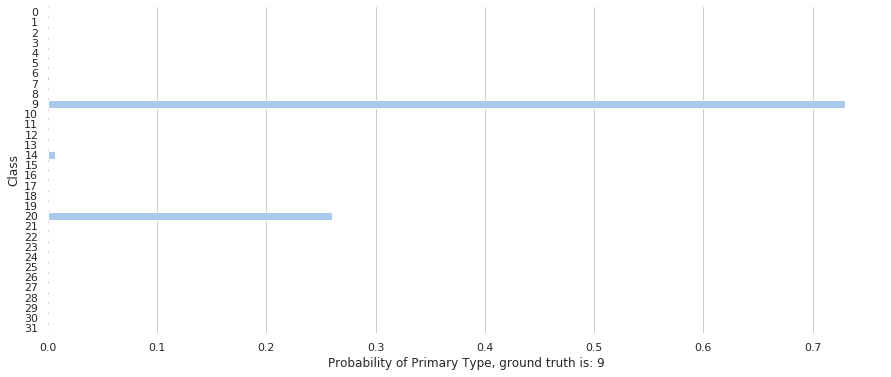

9

In [43]:
evaluate_single_case(row.drop('Primary Type'), target_type=target, visualize_dict=True)

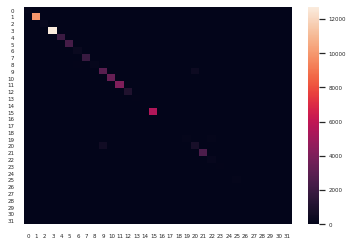

In [0]:
df_cm = pd.DataFrame(confusion_matrix, range(32), range(32))
sn.set(font_scale=0.5)
sn.heatmap(df_cm, annot=False, xticklabels=range(32), yticklabels=range(32))
plt.show()

Since the class seems not balance, let's normalize each row of the confusion matrix here

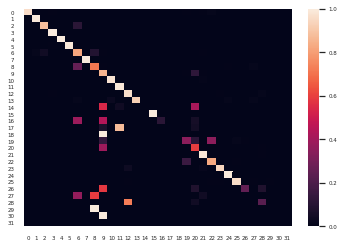

In [42]:
import numpy as np
new_confusion_matrix = confusion_matrix.copy()
'Last row is omitted, since the test set do not contains class 31'
for i in range(31):
  new_confusion_matrix[i] = confusion_matrix[i]/np.sum(confusion_matrix[i])
new_confusion_matrix.shape

df_cm = pd.DataFrame(new_confusion_matrix, range(32), range(32))
sn.set(font_scale=0.5)
sn.heatmap(df_cm, annot=False, xticklabels=range(32), yticklabels=range(32))
plt.show()